# 1) Transmon Qubit Simulator

### Quantum Hackathon 2025

Society of Quantum Engineers

San Jose State University

In [13]:
"""
Copyright (c) 2025 James Saslow
All rights reserved.

This software is proprietary but may be used for personal and educational purposes. 
Commercial use, modification, or distribution without prior written permission is prohibited.

For licensing inquiries, contact: jamessaslow@gmail.com or james.saslow@sjsu.edu
"""

'\nCopyright (c) 2025 James Saslow\nAll rights reserved.\n\nThis software is proprietary but may be used for personal and educational purposes. \nCommercial use, modification, or distribution without prior written permission is prohibited.\n\nFor licensing inquiries, contact: jamessaslow@gmail.com or james.saslow@sjsu.edu\n'

The Hamiltonian for a single transmon qubit can be described by the sum of a qubit Hamiltonian $H_{0}$ and a drive Hamiltonian $H_{d}$

$H = H_{0} + H_{d}$

where $H_{0} = -\frac{\omega_{q}}{2} \sigma_{z}$ and $H_{d} = \Omega V_{d}(t) \sigma_{y}$

I'll define all these variables below:

- $\omega_{q}$ is the qubit frequency, defined by the first two energy levels of the Transmon i.e. $E_{1} - E_{0} = \hbar \omega_{q}$

- $\sigma_{x}$, $\sigma_{y}$, and $\sigma_{z}$ are the usual Pauli Spin Matrices (https://en.wikipedia.org/wiki/Pauli_matrices)

- $\Omega$ is a parameter defined by the capacitances and impedance of the Transmon circuit (https://arxiv.org/abs/1904.06560 Pg 28)

- $V_d(t)$ is the microwave resonator written in terms of a driving time-dependent voltage source. In this notebook, I will define $V_d(t)$ to be a sinusoidal voltage encased in a Gaussian envelope.



**You can Ignore the Code below!**

**Just focus on the GUI at the end of the Script!**

In [14]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

from matplotlib.animation import FuncAnimation
import matplotlib
from ipywidgets import interact, widgets
from scipy.linalg import expm
from IPython.display import display, clear_output

In [15]:
!git clone https://github.com/jamessaslow/pyTransmon.git
import sys
sys.path.append('pyTransmon/')

fatal: destination path 'pyTransmon' already exists and is not an empty directory.


In [16]:
# Custom Package
from pyTransmon import Transmon

In [17]:
"""
Qubit Initial Conditions
"""

# Initial Conditions and time interval

def state_vec(theta, phi):
    return np.array([ np.cos(theta/2) , np.exp(1j*phi)*np.sin(theta/2) ])

t = np.linspace(0,6,10000)
psi = state_vec(0,0)

# Transmon Properties
wq = 20
W = 1

# Microwave Resonator Properties
stdev = 1
mu = 3
V0 = np.pi
delta = 0
wd = 20

frame = 'Qubit'

In [25]:
"""
Ignore this cell
"""


# Enable interactive mode for smoother updates
plt.ion()

# Create output widgets for the plots
bloch_output = widgets.Output()
voltage_output = widgets.Output()

# Global variables
frame = 'Qubit'
theta, phi = 0, 0  # Default state |0>

# Function to toggle the frame and update the plots
def toggle_frame(change):
    """ Toggle between 'Qubit' and 'Lab' frame when button is clicked """
    global frame
    frame = 'Lab' if frame == 'Qubit' else 'Qubit'
    frame_button.description = f"Frame: {frame}"  # Update button text
    update_plot(None)  # Re-run the simulation with new frame

# Function to set psi based on selected button
def set_state(change):
    """ Update psi's theta and phi based on selected state button """
    global theta, phi
    state_mapping = {
        "|0>": (0, 0),
        "|1>": (np.pi, 0),
        "|+>": (np.pi / 2, 0),
        "|->": (np.pi / 2, np.pi)
    }
    theta, phi = state_mapping[change.description]
    update_plot(None)  # Update simulation and plots

# Define the update function
def update_plot(change):
    """ Re-run qubit simulation and update plots when any slider or button changes """
    
    # Extract slider values
    wq_val = sliders["wq"].value
    W_val = sliders["W"].value
    V0_val = sliders["V0"].value
    delta_val = sliders["delta"].value
    wd_val = sliders["wd"].value
    stdev_val = sliders["stdev"].value
    tf_val = sliders["tf"].value

    # Re-run the simulation with updated values
    t = np.linspace(0, tf_val, 2000)
    psi = state_vec(theta=theta, phi=phi)  # Use updated theta and phi

    global myQubit  # Update the global myQubit object
    myQubit = Transmon(t, psi, wq_val, W_val, mu, stdev_val, V0_val, delta_val, wd_val, frame)
    myQubit.run()

    # Clear previous plots and redraw
    with bloch_output:
        clear_output(wait=True)
        myQubit.bloch_sphere_plot(axes=True, labels=True, legend=True, wavefunction=True, size=[7, 7])
        plt.show()

    with voltage_output:
        clear_output(wait=True)
        myQubit.voltage_plot()
        plt.show()

# Create slider widgets
sliders = {
    "wq": widgets.FloatSlider(value=23, min=0, max=30, step=0.1, description='\u03C9_q'),
    "W": widgets.FloatSlider(value=1, min=0, max=4, step=0.1, description='\u03A9'),
    "V0": widgets.FloatSlider(value=np.pi, min=0, max=7, step=0.01, description='V_0'),
    "delta": widgets.FloatSlider(value=0, min=-np.pi, max=np.pi, step=0.05, description='\u03B4'),
    "wd": widgets.FloatSlider(value=23, min=0, max=30, step=0.1, description='\u03C9_d'),
    "stdev": widgets.FloatSlider(value=1, min=0.1, max=1, step=0.1, description='\u03C3'),
    "tf": widgets.FloatSlider(value=6, min=0, max=6, step=0.2, description='t_f')
}

# Observe slider changes and trigger updates
for slider in sliders.values():
    slider.observe(update_plot, names="value")

# Create toggle button for switching frames
frame_button = widgets.Button(description=f"Frame: {frame}", button_style="primary")
frame_button.on_click(toggle_frame)

# Create state selection buttons
state_buttons = [
    widgets.Button(description="|0>", button_style="info"),
    widgets.Button(description="|1>", button_style="info"),
    widgets.Button(description="|+>", button_style="info"),
    widgets.Button(description="|->", button_style="info")
]

# Attach event handlers to state buttons
for btn in state_buttons:
    btn.on_click(set_state)

# Initialize qubit (runs simulation once with initial values)
update_plot(None)

# Arrange UI: Sliders vertically, state buttons below, plots side by side
ui_layout = widgets.HBox([
    widgets.VBox([
        frame_button,  # Frame switch button
        *list(sliders.values()),  # Sliders
        widgets.Label("Set Initial State:"),  # Label above state buttons
        widgets.HBox(state_buttons)  # Row of state buttons
    ], layout=widgets.Layout(width="30%")),  # Vertical column
    widgets.HBox([bloch_output, voltage_output], layout=widgets.Layout(width="70%"))  # Side-by-side plots
])

# Display UI
display(ui_layout)


# User Can Interact with the GUI Above

A superconducting transmon qubit interacts with a voltage source defined by

$$V_{d}(t) = s(t) V_{0} \text{sin}(\omega_{d} t + \delta) $$

where $\omega_{d}$ is the driving frequency, $\delta$ is the phase offset of the sine wave, and $s(t)$ is an envelope function.

$$s(t) = \frac{1}{\sqrt{2\pi \sigma}} e^{-\frac{(t-\mu)^{2}}{2\sigma^{2}}}$$

Different voltage signals create different single qubit gates!

The in-phase component is defined as 

$$I_{\delta} = \text{cos}(\delta)$$

and the out of phase component is defined as 

$$Q_{\delta} = \text{sin}(\delta)$$

We have a special time-dependent angle called $\Theta(t)$

$$\Theta(t) = -\Omega V_{0} \int_{0}^{t} s(t') dt'$$


# ***Questions***

______________________________________________________________________________________

### 1) What does each knob/button appear to do for the initial setup of the simulator? 

- If you want to reset it, simply re-run the cell above the GUI

In [19]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### ***Solution***


$V_{0}$ and $\Omega$ seem to change the magnitude of the voltage pulse. $\sigma$ changes the standard deviation of the voltage pulse. $\delta$ changes the phase of the sine wave and axis of rotation on the Bloch Sphere. $\omega_{q}$ is the qubit frequency and $\omega_{d}$ is the driving frequency of the voltage source. Making these frequencies different introduces detuning in our system. Lastly, $t_{f}$ tracks the time evolution of our system.

The Frame buttom switches between the qubit frame and the lab frame. Measurements are always taken in the lab frame, but interpreted in the qubit frame.

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


______________________________________________________________________________________

### 2) What is the Scheme for creating an $X$-Gate?

- What is the difference between $Y\ket{0}$ and $X\ket{0}$ when you do the matrix multiplication? How do you know for certain that your pulse sequence procedure is an $X$ gate?

- What happens if we apply an $X$ to $\ket{0}$, and then apply an $X$ gate *again*? What is the final state of the qubit? What path does the qubit state take on the Bloch Sphere?



~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### ***Solution***


We know for certain that our pulse sequence is an $X$ gate if and only if

$$X \ket{0} = \ket{1}$$

$$X \ket{1} = \ket{0}$$

$$X \ket{+} = \ket{+}$$

$$X \ket{-} = - \ket{-}$$




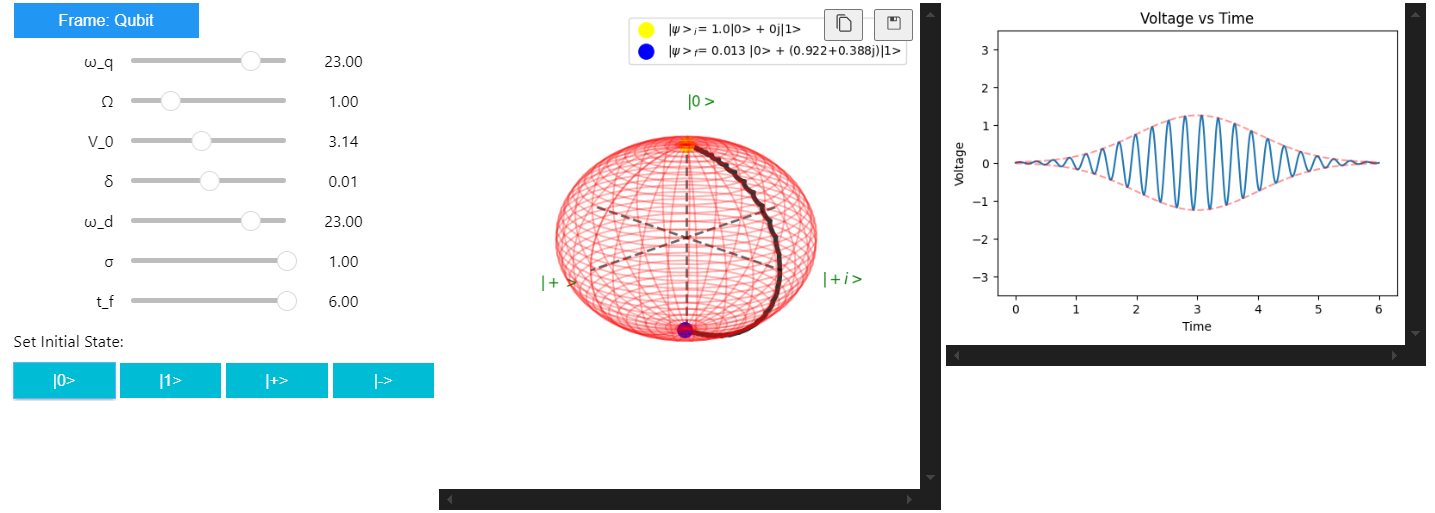
$X \ket{0} = \ket{1}$ (Above)



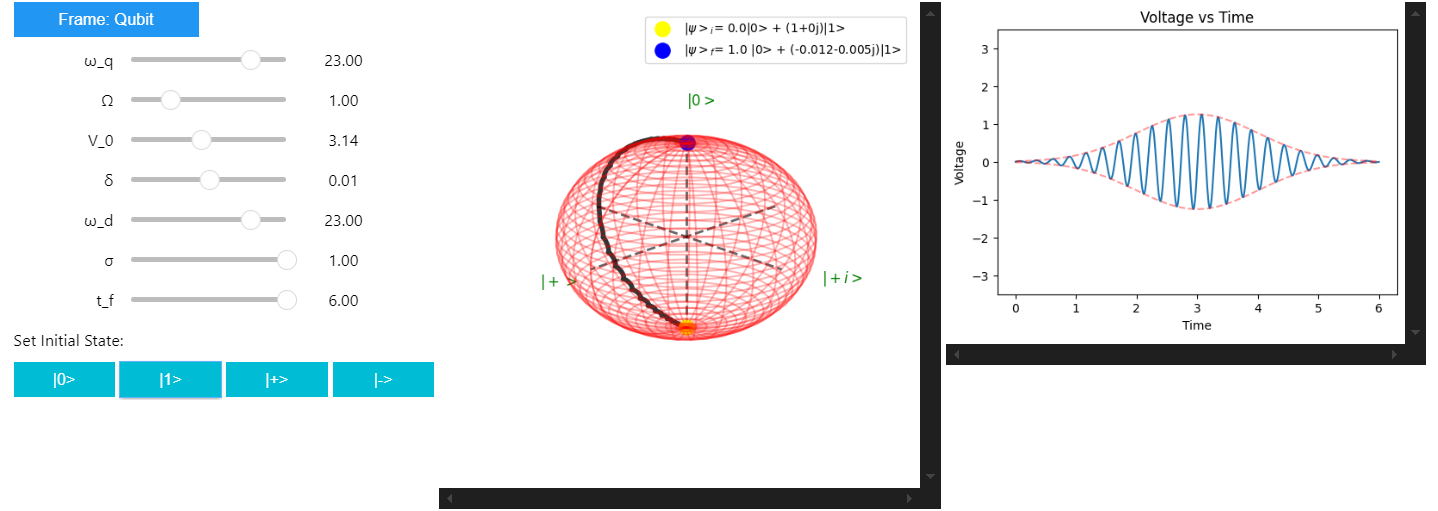
$X \ket{1} = \ket{0}$ (Above)


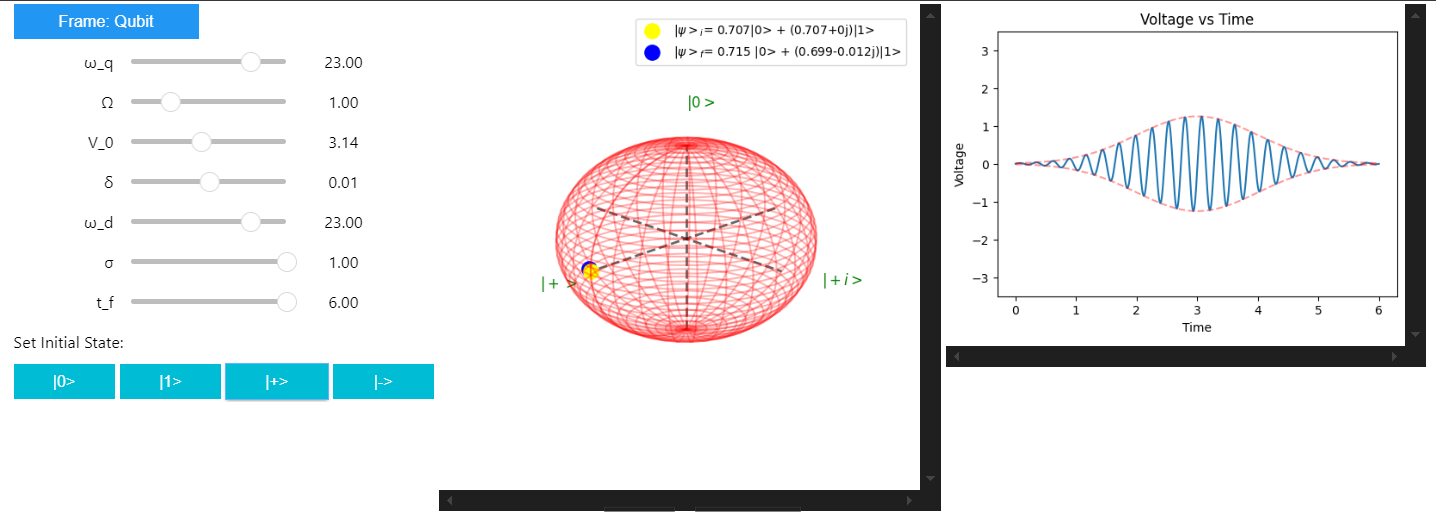
$X \ket{+} = \ket{+}$ (Above)


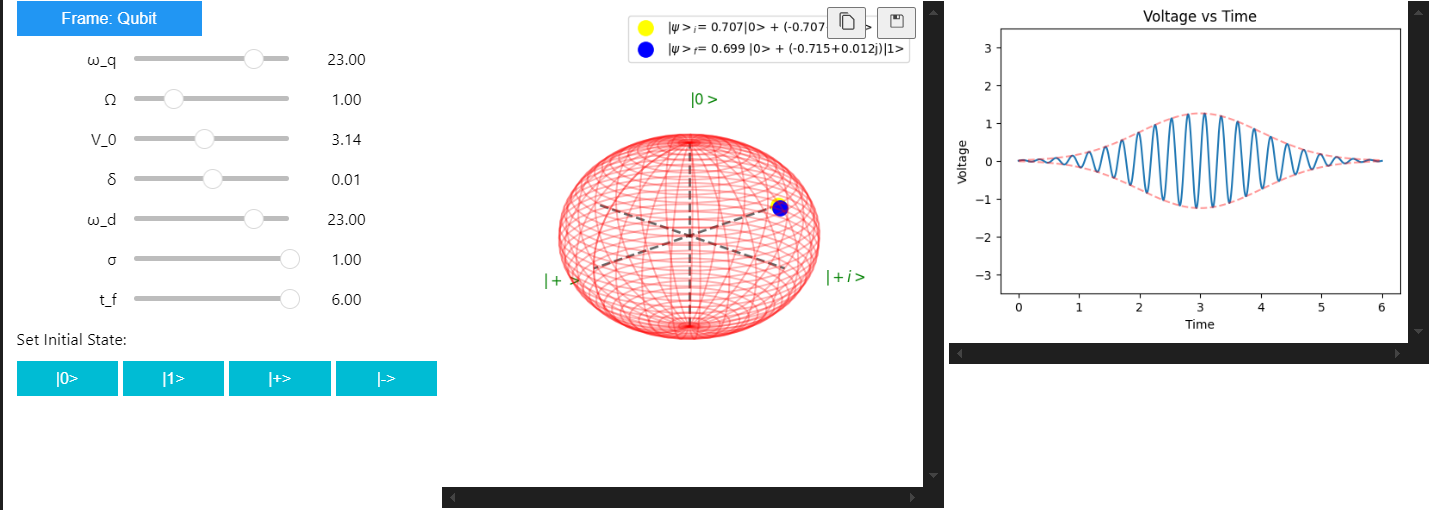
$X \ket{-} = - \ket{-}$ (Above)


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


In [20]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

# ==========================================================================

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

______________________________________________________________________________________

### 3) How can you create a $\sqrt{\text{X}}$ gate?

In [21]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### ***Solution***


What's a $\sqrt{X}$ gate? Well, two $\sqrt{X}$ gates get you an $X$ gate! 

It turns out that the method for implementing a $\sqrt{X}$ gate is the same as the $X$ gate, but with half the amount of voltage! 

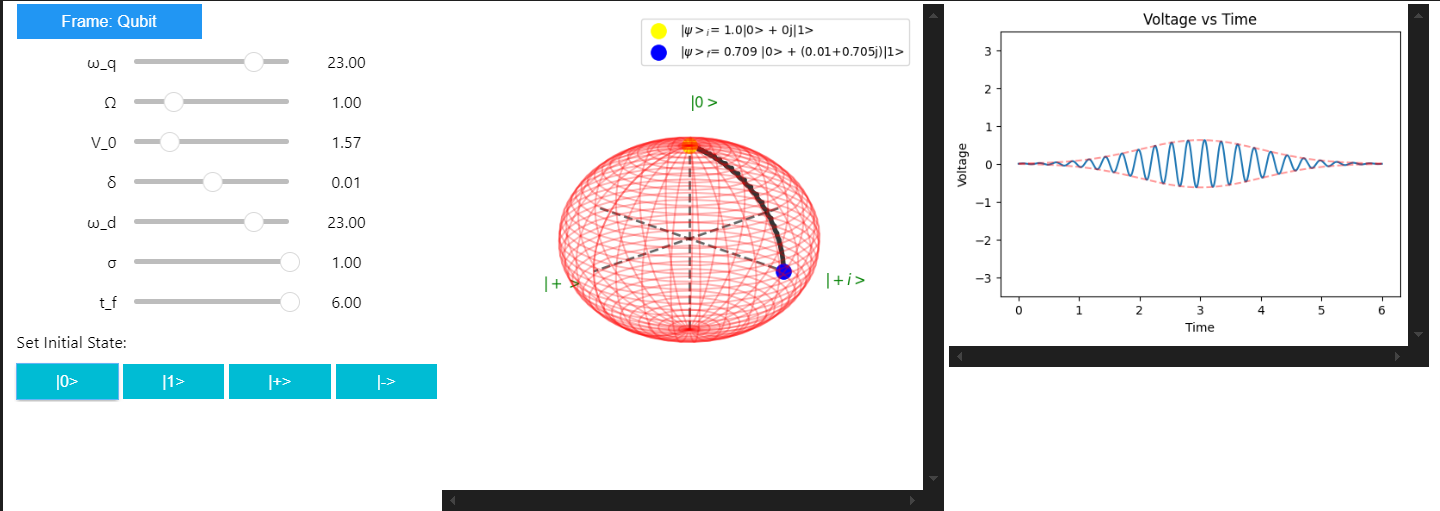

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


______________________________________________________________________________________

### 4) What pulse sequence can you use to create a Hadamard $H$ gate?

Verify that your sequence is indeed the Hadamard gate by transforming the $\ket{+}$ and $\ket{-}$ states with your pulse sequence.



In [22]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

Because the Hadamard gate is a result of a combination of Pauli's, the procedure for a Hadamard gate is expressed in terms of a *pulse sequence*.

We can write the Hadamard gate as 

$$H = X \sqrt{Y}$$

which means do a $\sqrt{Y}$ pulse then follow up with an $X$ gate.

This means we have to perform exactly *two* pulses to achieve a Hadamard gate.


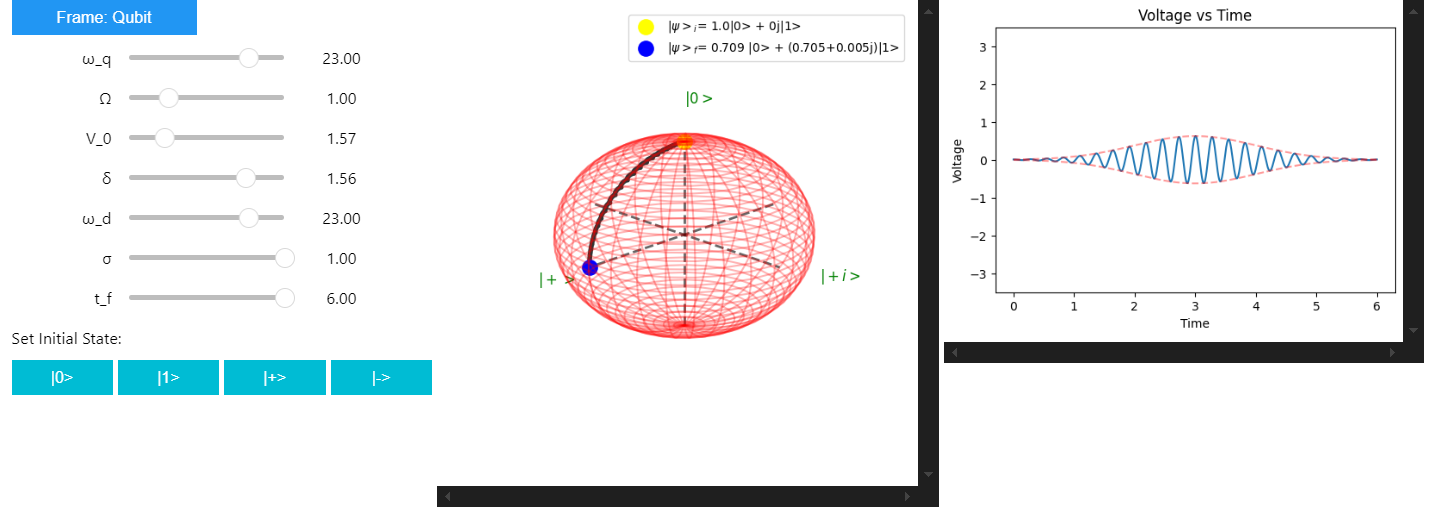
First, we do $\sqrt{Y}$ on the $\ket{0}$ state (Above) which transforms $\ket{0} \rightarrow \ket{+}$ Next we perform $X$ on $\ket{+}$ which is an eigenstate of $X$.

Therefore, $H\ket{0} = \ket{+}$


Similar analysis reveals that $H\ket{1} = \ket{-}$

______________________________________________________________________________________

### 4) What does the qubit do naturally without any external voltage source applied to it?

- In the *qubit* frame? In the *lab* frame? What's the difference between the two frames? Which frame do we measure the state of our qubit in and why?


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### ***Solution***

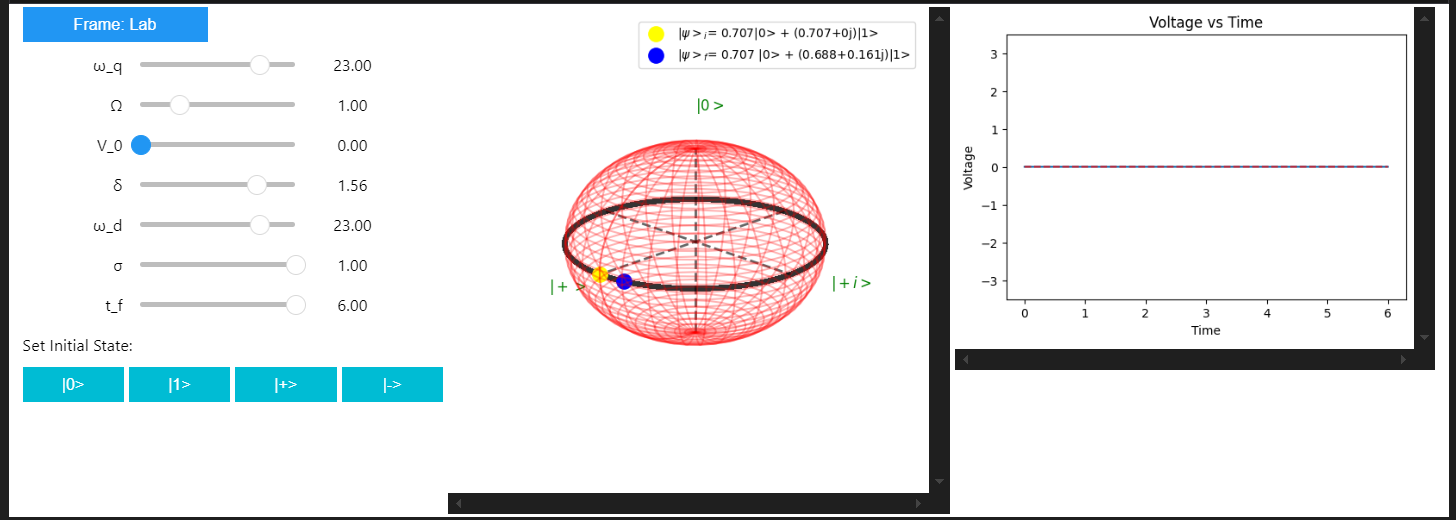


Without a voltage source applied to our qubit, the qubit naturally undergoes Larmour precession. This is visually evident if we switch our qubit perspective to  the lab frame.

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


In [28]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

______________________________________________________________________________________

### 5) What pulse sequence can you use to create a $Z$ gate?

- Say we have two qubits both initialized in the $\ket{+}$ state. We want to apply the $Z$ gate to one of them and the $I$ gate to the other simultaneously. Does your procedure for the $Z$ gate work?



In [24]:
"""
Your Answer (You can switch to Markdown if you prefer Latex typing)
"""

'\nYour Answer (You can switch to Markdown if you prefer Latex typing)\n'

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

### ***Solution***

A misconception is that to do a $Z$ gate we don't do anything and the qubit will rotate along the $Z$ axis automatically. However, suppose we have two qubits. If we want to make a phase difference between the two qubits, we would need to *boost* the qubit frequency of one to offset the relative phase difference from one qubit to another. Therefore, we cannot just perform a Z gate utilizing the qubit Larmour precession. Instead, we have to leverage $x$ and $y$ rotations to create a virtual $Z$-gate.

In fact,

$$\sigma_{z} = -i \sigma_{x} \sigma_{y}$$

Therefore, to do a $Z$ gate, we need to do a $Y$ gate then an $X$ gate.


~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
